Capstone Project

Tornado Analysis

In [358]:
pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 217.9 kB/s eta 0:07:38
   ---------------------------------------- 0.1/99.8 MB 381.3 kB/s eta 0:04:22
   ---------------------------------------- 0.1/99.8 MB 467.6 kB/s eta 0:03:34
   ---------------------------------------- 0.2/99.8 MB 765.3 kB/s eta 0:02:11
   ---------------------------------------- 0.5/99.8 MB 1.5 MB/s eta 0:01:05
   ---------------------------------------- 0.9/99.8 MB 2.3 MB/s eta 0:00:43
    --------------------------------------- 

In [365]:
pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.3 MB 495.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.3 MB 1.5 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.3 MB 2.4 MB/s eta 0:00:01
   -------------------------- ------------- 0.9/1.3 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
pd.set_option('display.max_columns', None)

In [207]:
df1 = pd.read_csv('data/weather1.csv')
df2 = pd.read_csv('data/weather2.csv')
df3 = pd.read_csv('data/weather3.csv')
df4 = pd.read_csv('data/weather4.csv')
df5 = pd.read_csv('data/weather5.csv')
df6 = pd.read_csv('data/weather6.csv')

In [208]:
df = pd.concat([df1,df2,df3,df4,df5,df6],ignore_index=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df['hour'] = df['time'].str[:2].astype(int)

In [209]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl,hour
0,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.00,0.0,39.3300,-88.4500,39.3300,-88.4000,2.50,50,11.525623,24.863468,1011.299988,15.273505,29.899511,1011.099976,18.129137,33.908863,1010.599976,17.639999,33.190357,1010.799988,16.622490,31.311724,1010.700012,15.158522,29.888672,1010.599976,14.759999,28.943642,1010.200012,14.799459,29.195534,1009.900024,15.226764,29.882170,1009.500000,15.941944,30.599998,1009.000000,15.844090,30.141266,1009.099976,15.273505,29.888672,1008.700012,16.595179,31.452133,1008.599976,18.861387,33.805515,1008.200012,19.486610,32.789658,1008.000000,21.240000,31.328272,1007.799988,22.553936,32.078403,1007.599976,23.313995,33.092594,1006.799988,23.344549,33.014175,1006.400024,24.967497,35.428459,1005.799988,22.539564,32.846920,1004.900024,17.873554,29.035288,1004.099976,17.935081,31.178993,1004.099976,16.923830,29.795301,1005.099976,17
1,1996,10,21,1996-10-21,07:00:00,TX,48,1,0,0,0.04,0.0,32.4000,-97.8000,32.4000,-97.8000,0.50,40,12.924953,27.804028,1003.200012,16.676977,32.908016,1004.099976,20.674158,37.550602,1004.599976,24.122683,41.425034,1004.799988,24.216522,41.750687,1005.299988,23.576563,40.541180,1004.900024,22.424271,38.896660,1005.200012,20.929596,36.302925,1005.099976,18.448023,32.023815,1005.599976,15.584300,27.047956,1005.700012,6.489992,14.336861,1005.900024,7.695920,16.854767,1006.299988,10.514218,20.523157,1007.700012,9.360001,16.923830,1008.400024,12.101570,20.188908,1008.799988,5.495161,8.435069,1009.599976,2.902413,3.758510,1008.799988,3.600000,4.072935,1008.900024,6.297428,8.287822,1009.000000,6.379216,8.311245,1007.700012,3.976330,5.411986,1006.900024,1.938659,2.414953,1006.299988,10.829958,14.241630,1005.799988,15.937878,23.452555,1007.200012,7
2,1996,10,21,1996-10-21,08:35:00,TX,48,1,7,0,3.00,0.0,32.7700,-96.7800,32.7700,-96.7800,0.50,50,19.586117,33.893574,1004.099976,23.688984,39.557430,1004.700012,26.368616,43.211998,1005.200012,28.551426,45.047493,1005.599976,29.250967,45.468437,1006.299988,30.035742,47.446304,1006.000000,27.155552,47.373863,1006.400024,27.820337,43.631348,1006.099976,26.437336,41.859192,1006.299988,25.562534,39.961620,1006.000000,16.071491,27.210379,1005.900024,14.494192,24.933735,1006.200012,13.320000,23.806318,1007.500000,16.199999,26.574244,1008.099976,12.303366,20.447239,1008.599976,7.568566,13.679999,1009.599976,5.154415,7.653705,1009.400024,6.877789,8.209263,1009.099976,10.990322,13.217443,1008.400024,10.948973,13.7

In [ ]:
'''
Visualizations:

Show hour count and magnitude count for reasoning
Other interesting plots: month, more, etc

In [9]:
df.value_counts('mag')

mag
 0    15686
 1     7184
 2     1973
 3      566
-9      293
 4      123
 5       14
Name: count, dtype: int64

In [210]:
hour_counts = df['hour'].value_counts().sort_index()
month_counts = df['mo'].value_counts().sort_index()
year_counts = df['yr'].value_counts().sort_index()

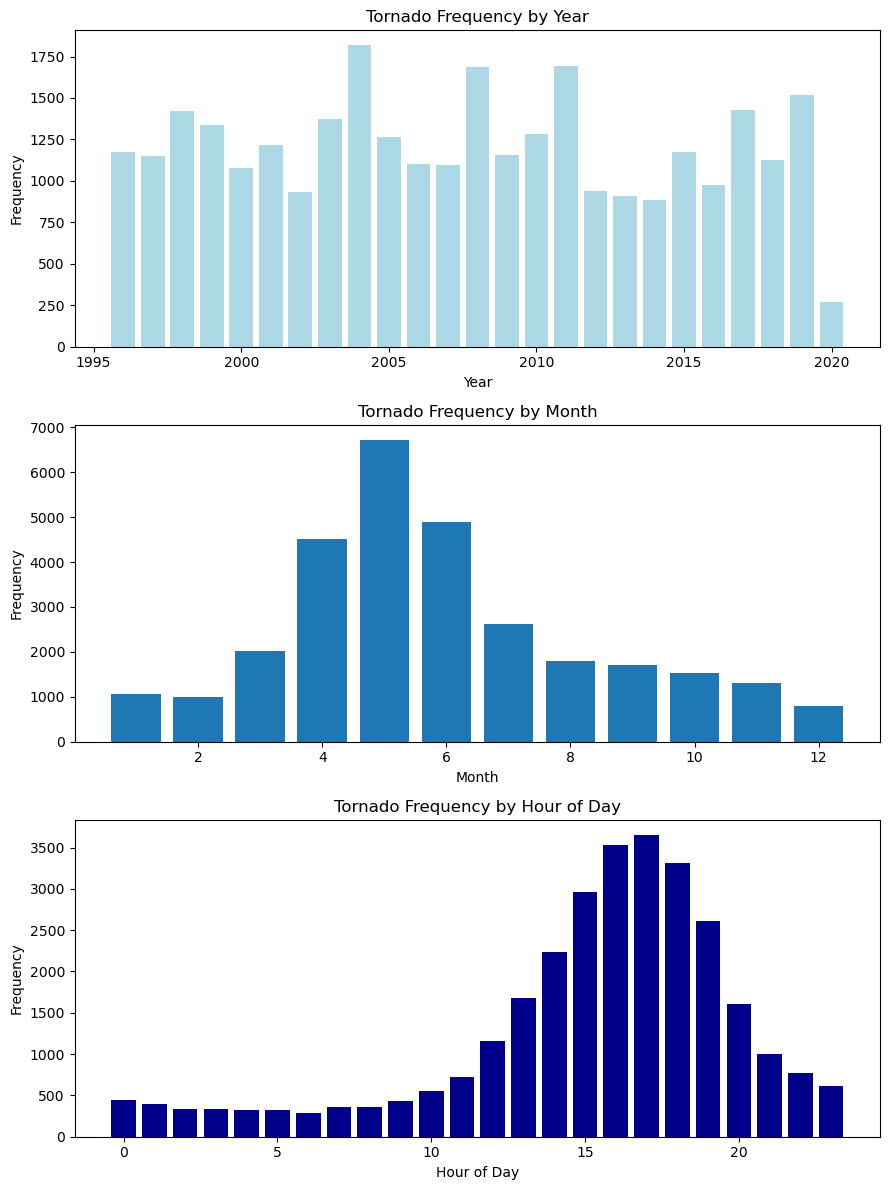

In [211]:
fig, axes = plt.subplots(3, 1, figsize=(9, 12))

#year
axes[0].bar(year_counts.index, year_counts.values, color='lightblue')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Tornado Frequency by Year')

#month
axes[1].bar(month_counts.index, month_counts.values)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Tornado Frequency by Month')

#hour
axes[2].bar(hour_counts.index, hour_counts.values, color='darkblue')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Tornado Frequency by Hour of Day')

plt.tight_layout()
plt.show()

In [222]:
hour_counts.to_csv('data/daysviz.csv')

In [ ]:
'''
remove hours before 11
remove unknown magnitudes

In [18]:
df = df[(df['hour'] >= 11)]
df = df[df['mag'] != -9]

In [19]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl,hour
0,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.00,0.0,39.3300,-88.4500,39.3300,-88.4000,2.50,50,11.525623,24.863468,1011.299988,15.273505,29.899511,1011.099976,18.129137,33.908863,1010.599976,17.639999,33.190357,1010.799988,16.622490,31.311724,1010.700012,15.158522,29.888672,1010.599976,14.759999,28.943642,1010.200012,14.799459,29.195534,1009.900024,15.226764,29.882170,1009.500000,15.941944,30.599998,1009.000000,15.844090,30.141266,1009.099976,15.273505,29.888672,1008.700012,16.595179,31.452133,1008.599976,18.861387,33.805515,1008.200012,19.486610,32.789658,1008.000000,21.240000,31.328272,1007.799988,22.553936,32.078403,1007.599976,23.313995,33.092594,1006.799988,23.344549,33.014175,1006.400024,24.967497,35.428459,1005.799988,22.539564,32.846920,1004.900024,17.873554,29.035288,1004.099976,17.935081,31.178993,1004.099976,16.923830,29.795301,1005.099976,17
5,1996,10,21,1996-10-21,14:15:00,TX,48,0,0,0,0.00,0.0,31.7300,-98.0800,31.7300,-98.0800,0.10,30,16.946787,32.023815,1004.000000,20.969805,36.871452,1004.799988,22.033648,37.483242,1005.599976,22.682856,38.526726,1006.000000,23.762726,39.640884,1006.500000,24.881702,41.230606,1006.099976,24.967499,40.633778,1006.200012,23.933907,38.592266,1005.799988,22.104116,35.638180,1006.000000,20.929596,32.169178,1005.900024,15.119999,23.784531,1006.000000,13.797912,22.963936,1006.400024,14.007655,23.031561,1007.799988,9.826088,18.218275,1008.099976,9.826088,16.746773,1008.099976,6.489992,9.746631,1008.900024,4.693826,6.608722,1008.599976,7.559999,9.746631,1008.500000,13.397612,19.110542,1008.000000,16.575644,24.480000,1008.299988,8.913181,11.525623,1007.099976,5.495161,6.409617,1006.599976,10.883676,14.277983,1005.700012,10.163227,14.372974,1006.500000,14
6,1996,10,21,1996-10-21,14:26:00,TX,48,1,0,0,0.04,0.0,33.1700,-94.5000,33.1200,-94.1500,22.00,25,15.137133,27.811018,1006.799988,17.533146,31.205997,1007.000000,17.106628,30.735231,1007.799988,16.343367,29.986076,1008.000000,14.764389,26.642431,1008.799988,13.755580,25.455843,1008.799988,15.158522,27.645092,1008.900024,16.563911,29.239891,1008.000000,16.919998,30.274265,1007.700012,16.235960,29.301878,1007.700012,10.805998,21.178896,1007.400024,5.760000,11.503113,1008.500000,2.902413,6.120000,1009.900024,2.099143,4.334974,1010.400024,7.244860,14.145756,1010.400024,12.434340,22.086521,1010.599976,14.512064,24.648829,1010.599976,14.154915,22.505037,1010.700012,13.339445,20.548401,1010.099976,13.6277

In [20]:
#calculate average of 10hours leading up to tornado
#initialize columns
df['Average_Wind_Speed_10m'] = 0
df['Average_Wind_Speed_100m'] = 0
df['Average_Pressure_msl'] = 0

#iterate over each row to calculate the average
for index, row in df.iterrows():
    hour_value = row['hour']

    #calculate current hour index, and 9 hours before
    current_hour_index = (hour_value - 12) * 3
    preceding_hour_indices = [current_hour_index - i * 3 for i in range(1, 10)]

    #sum the values for the corresponding weather factors
    for i, factor in enumerate(['Wind_Speed_10m', 'Wind_Speed_100m', 'Pressure_msl']):
        current_col = f"{hour_value:02d}:00_{factor}"
        preceding_cols = [f"{(hour_value - i):02d}:00_{factor}" for i in range(1, 10)]
        
        #calculate the sum for the current row and factor
        sum_value = row[current_col] + sum(row[preceding_col] for preceding_col in preceding_cols)
        
        #calculate the average
        average_value = sum_value / 10
        
        #assign the average to the corresponding new column
        df.at[index, f'Average_{factor}'] = average_value

C:\Users\15199\AppData\Local\Temp\ipykernel_25468\1281024292.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18.433741092681885' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, f'Average_{factor}'] = average_value
C:\Users\15199\AppData\Local\Temp\ipykernel_25468\1281024292.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '31.50586814880371' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, f'Average_{factor}'] = average_value
C:\Users\15199\AppData\Local\Temp\ipykernel_25468\1281024292.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1008.3299926757812' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, f'A

In [ ]:
#since most tornadoes happen around 4-5 pm, I was able to drop late night and early morning tornadoes without losing too much data
#this makes it easier to get hours leading up to the torndao, and also gives a more reasonable 'baseline'
#eg we want to understand the average weather from the morning of the storm, up until the storm, as opposed to having to look at the weather 
#from late last night until 11am, for example

In [21]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl,hour,Average_Wind_Speed_10m,Average_Wind_Speed_100m,Average_Pressure_msl
0,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.00,0.0,39.3300,-88.4500,39.3300,-88.4000,2.50,50,11.525623,24.863468,1011.299988,15.273505,29.899511,1011.099976,18.129137,33.908863,1010.599976,17.639999,33.190357,1010.799988,16.622490,31.311724,1010.700012,15.158522,29.888672,1010.599976,14.759999,28.943642,1010.200012,14.799459,29.195534,1009.900024,15.226764,29.882170,1009.500000,15.941944,30.599998,1009.000000,15.844090,30.141266,1009.099976,15.273505,29.888672,1008.700012,16.595179,31.452133,1008.599976,18.861387,33.805515,1008.200012,19.486610,32.789658,1008.000000,21.240000,31.328272,1007.799988,22.553936,32.078403,1007.599976,23.313995,33.092594,1006.799988,23.344549,33.014175,1006.400024,24.967497,35.428459,1005.799988,22.539564,32.846920,1004.900024,17.873554,29.035288,1004.099976,17.935081,31.178993,1004.099976,16.923830,29.795301,1005.099976,17,18.433741,31.505868,1008.329993
5,1996,10,21,1996-10-21,14:15:00,TX,48,0,0,0,0.00,0.0,31.7300,-98.0800,31.7300,-98.0800,0.10,30,16.946787,32.023815,1004.000000,20.969805,36.871452,1004.799988,22.033648,37.483242,1005.599976,22.682856,38.526726,1006.000000,23.762726,39.640884,1006.500000,24.881702,41.230606,1006.099976,24.967499,40.633778,1006.200012,23.933907,38.592266,1005.799988,22.104116,35.638180,1006.000000,20.929596,32.169178,1005.900024,15.119999,23.784531,1006.000000,13.797912,22.963936,1006.400024,14.007655,23.031561,1007.799988,9.826088,18.218275,1008.099976,9.826088,16.746773,1008.099976,6.489992,9.746631,1008.900024,4.693826,6.608722,1008.599976,7.559999,9.746631,1008.500000,13.397612,19.110542,1008.000000,16.575644,24.480000,1008.299988,8.913181,11.525623,1007.099976,5.495161,6.409617,1006.599976,10.883676,14.277983,1005.700012,10.163227,14.372974,1006.500000,14,17.939456,29.300908,1006.639996
6,1996,10,21,1996-10-21,14:26:00,TX,48,1,0,0,0.04,0.0,33.1700,-94.5000,33.1200,-94.1500,22.00,25,15.137133,27.811018,1006.799988,17.533146,31.205997,1007.000000,17.106628,30.735231,1007.799988,16.343367,29.986076,1008.000000,14.764389,26.642431,1008.799988,13.755580,25.455843,1008.799988,15.158522,27.645092,1008.900024,16.563911,29.239891,1008.000000,16.919998,30.274265,1007.700012,16.235960,29.301878,1007.700012,10.805998,21.178896,1007.400024,5.760000,11.503113,1008.500000,2.902413,6.120000,1009.900024,2.099143,4.334974,1010.400024,7.244860,14.145756,1010.400024,12.

In [24]:
#saving cleaned dataframe with averages added
#df.to_csv('data/complete.csv')

In [218]:
df = pd.read_csv('data/complete.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [217]:
df

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl,hour
0,1996,10,17,1996-10-17,17:40:00,IL,17,0,1,0,0.00,0.0,39.3300,-88.4500,39.3300,-88.4000,2.50,50,11.525623,24.863468,1011.299988,15.273505,29.899511,1011.099976,18.129137,33.908863,1010.599976,17.639999,33.190357,1010.799988,16.622490,31.311724,1010.700012,15.158522,29.888672,1010.599976,14.759999,28.943642,1010.200012,14.799459,29.195534,1009.900024,15.226764,29.882170,1009.500000,15.941944,30.599998,1009.000000,15.844090,30.141266,1009.099976,15.273505,29.888672,1008.700012,16.595179,31.452133,1008.599976,18.861387,33.805515,1008.200012,19.486610,32.789658,1008.000000,21.240000,31.328272,1007.799988,22.553936,32.078403,1007.599976,23.313995,33.092594,1006.799988,23.344549,33.014175,1006.400024,24.967497,35.428459,1005.799988,22.539564,32.846920,1004.900024,17.873554,29.035288,1004.099976,17.935081,31.178993,1004.099976,16.923830,29.795301,1005.099976,17
1,1996,10,21,1996-10-21,07:00:00,TX,48,1,0,0,0.04,0.0,32.4000,-97.8000,32.4000,-97.8000,0.50,40,12.924953,27.804028,1003.200012,16.676977,32.908016,1004.099976,20.674158,37.550602,1004.599976,24.122683,41.425034,1004.799988,24.216522,41.750687,1005.299988,23.576563,40.541180,1004.900024,22.424271,38.896660,1005.200012,20.929596,36.302925,1005.099976,18.448023,32.023815,1005.599976,15.584300,27.047956,1005.700012,6.489992,14.336861,1005.900024,7.695920,16.854767,1006.299988,10.514218,20.523157,1007.700012,9.360001,16.923830,1008.400024,12.101570,20.188908,1008.799988,5.495161,8.435069,1009.599976,2.902413,3.758510,1008.799988,3.600000,4.072935,1008.900024,6.297428,8.287822,1009.000000,6.379216,8.311245,1007.700012,3.976330,5.411986,1006.900024,1.938659,2.414953,1006.299988,10.829958,14.241630,1005.799988,15.937878,23.452555,1007.200012,7
2,1996,10,21,1996-10-21,08:35:00,TX,48,1,7,0,3.00,0.0,32.7700,-96.7800,32.7700,-96.7800,0.50,50,19.586117,33.893574,1004.099976,23.688984,39.557430,1004.700012,26.368616,43.211998,1005.200012,28.551426,45.047493,1005.599976,29.250967,45.468437,1006.299988,30.035742,47.446304,1006.000000,27.155552,47.373863,1006.400024,27.820337,43.631348,1006.099976,26.437336,41.859192,1006.299988,25.562534,39.961620,1006.000000,16.071491,27.210379,1005.900024,14.494192,24.933735,1006.200012,13.320000,23.806318,1007.500000,16.199999,26.574244,1008.099976,12.303366,20.447239,1008.599976,7.568566,13.679999,1009.599976,5.154415,7.653705,1009.400024,6.877789,8.209263,1009.099976,10.990322,13.217443,1008.400024,10.948973,13.7

In [219]:
import ipywidgets

def speed_by_mag(magnitude):
    filtered_df = df[df['mag'] == magnitude]

    avg_wind_speed_10m = filtered_df['Average_Wind_Speed_10m'].mean()
    avg_wind_speed_100m = filtered_df['Average_Wind_Speed_100m'].mean()

    positions = [0.5, 0.9]

    plt.figure(figsize=(6, 5))

    plt.bar(positions, [avg_wind_speed_10m, avg_wind_speed_100m], width=0.2)
    plt.xticks(positions, ['Wind Speed (10m)', 'Wind Speed (100m)'])
    plt.xlabel('Wind Speed Measurement')
    plt.ylabel('Average Wind Speed')
    plt.title(f'Average Wind Speeds at Different Heights for Magnitude {magnitude}')
    plt.ylim(0, 40)
    plt.show()

In [221]:
ipywidgets.interact(speed_by_mag, magnitude=(0,5,1))

interactive(children=(IntSlider(value=2, description='magnitude', max=5), Output()), _dom_classes=('widget-int…

<function __main__.speed_by_mag(magnitude)>

In [29]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['len']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()
results.summary()

#Linear regression - shows correlation, but poor predictive power

#Len gives p values of 0.00 for each of my weather conditions, making it a strong contender to predict
#according to this, higher wins speeds at 100m result in a longer tornado path, while higher wind speeds at 10m result in a shorter path
#This likely has to do with wind shear - the difference in wind speeds and directions at different altitudes are a large factor in the formation of a tornado
#Also, lower pressure (at mean sea level) is predictive of a longer tornado

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    len   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     217.3
Date:                Fri, 12 Apr 2024   Prob (F-statistic):          3.22e-139
Time:                        13:56:54   Log-Likelihood:                -81731.
No. Observations:               25546   AIC:                         1.635e+05
Df Residuals:                   25542   BIC:                         1.635e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      95.5528      8.213     11.634      0.000      79.454     111.651
Average_Wind_Speed_10m     -0.3432      0.023    -14.676      0.000      -0.389      -0.297
Average_Wind_Speed_100m     0.2687      0.015     17.377      0.000       0.238       0.299
Average_Pressure_msl       -0.0931      0.008    -11.514      0.000      -0.109      -0.077
==============================================================================
Omnibus:                    29745.848   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4778601.811
Skew:                           6.025   Prob(JB):                         0.00
Kurtosis:                      68.911   Cond. No.                     2.24e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

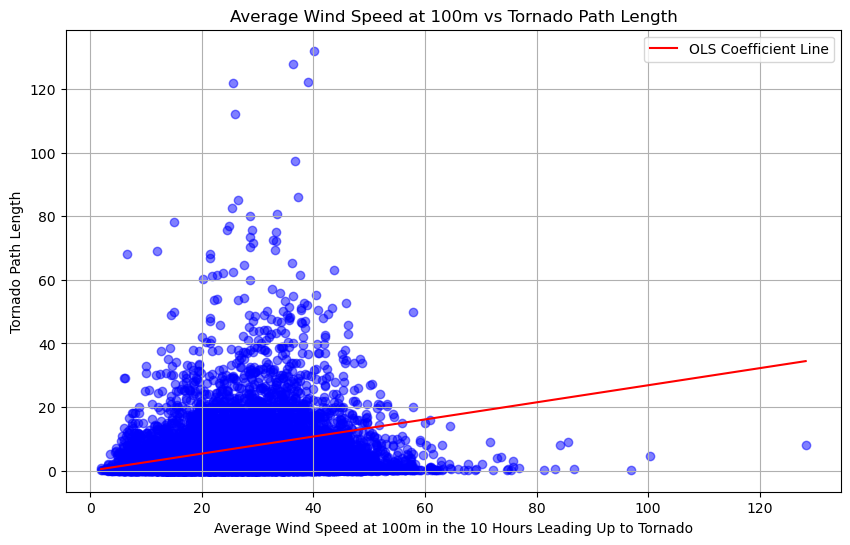

In [30]:
#visulization of relationship

coefficient_value = results.params['Average_Wind_Speed_100m']

wind_speed_values = np.linspace(min(df['Average_Wind_Speed_100m']), max(df['Average_Wind_Speed_100m']), 100)

predicted_path_length = coefficient_value * wind_speed_values

plt.figure(figsize=(10, 6))
plt.scatter(df['Average_Wind_Speed_100m'], df['len'], color='blue', alpha=0.5)

plt.plot(wind_speed_values, predicted_path_length, color='red', label='OLS Coefficient Line')

plt.title('Average Wind Speed at 100m vs Tornado Path Length')
plt.xlabel('Average Wind Speed at 100m in the 10 Hours Leading Up to Tornado')
plt.ylabel('Tornado Path Length')
plt.legend()
plt.grid(True)

plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)
results = model.fit()

y_pred = results.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 33.88912858447809
Root Mean Squared Error (RMSE): 5.821436986215525
Mean Absolute Error (MAE): 3.2238898048560625
R-squared (R2) Score: 0.01908388053836374


In [194]:
#confirming that OLS is not very effective for predicting

Classification

GBM

In [34]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['mag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
gbmclass = GradientBoostingClassifier(random_state=42)
gbmclass.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [36]:
y_pred_gbm = gbmclass.predict(X_test)

accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print("GBM Accuracy:", accuracy_gbm)

print("GBM Classification Report:")
print(classification_report(y_test, y_pred_gbm))

GBM Accuracy: 0.6174168297455969
GBM Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.99      0.76      3176
           1       0.38      0.01      0.01      1403
           2       0.00      0.00      0.00       400
           3       0.09      0.01      0.02       106
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         3

    accuracy                           0.62      5110
   macro avg       0.18      0.17      0.13      5110
weighted avg       0.49      0.62      0.48      5110



Random Forest

In [37]:
rfclass = RandomForestClassifier(random_state=42)
rfclass.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = rfclass.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5906066536203523
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.84      0.74      3176
           1       0.35      0.22      0.27      1403
           2       0.28      0.07      0.11       400
           3       0.14      0.04      0.06       106
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         3

    accuracy                           0.59      5110
   macro avg       0.24      0.20      0.20      5110
weighted avg       0.53      0.59      0.54      5110



In [ ]:
#even the most accurate classifier cannot predict the 5 or 4 category, because there are so little of them - i will combine these high severity ones
#into one group for better classification

SVM

In [39]:
svmclass = SVC(kernel='rbf', random_state=42)
svmclass.fit(X_train, y_train)

SVC(random_state=42)

In [40]:
y_pred_svm = svmclass.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.6215264187866928
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      3176
           1       0.00      0.00      0.00      1403
           2       0.00      0.00      0.00       400
           3       0.00      0.00      0.00       106
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         3

    accuracy                           0.62      5110
   macro avg       0.10      0.17      0.13      5110
weighted avg       0.39      0.62      0.48      5110



C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15199\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
#from the initial tests, its clear the model is having a hard time predicting the higher magnitudes, due to their rarity
#even magnitude 3 is under 3% of tornadoes, therefore, I will combine magnitudes 3, 4, and 5 into one 'high severity' category
#as i move on to try some hyperparameter tuning, along with new models

In [41]:
df['mag'] = df['mag'].replace(5, 4)

In [42]:
df['mag'] = df['mag'].replace(4, 3)

In [68]:
df['mag'] = df['mag'].replace(3, 2)

In [44]:
#this is a much more reasonable spread, we still have a very low proportion of storms at a high level - which reflects the rarity of such a strom in real life
#however, we are not forcing the model to attempt to correctly categorize a single storm as a 5, out of the whole testing set
df.value_counts('mag')

mag
0    15686
1     7184
2     1973
3      703
Name: count, dtype: int64

In [69]:
X = df[['Average_Wind_Speed_10m', 'Average_Wind_Speed_100m', 'Average_Pressure_msl']]
y = df['mag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
'''
hyper parameter testing random forest

In [48]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.6213307240704501


In [49]:
param_dist = {
    'n_estimators': randint(50, 500),
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

rf_classifier = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = random_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 389}
Accuracy: 0.6215264187866928


In [ ]:
'''
testing best parameters random forest - BEST SO FAR

In [115]:
tunedRFclass = RandomForestClassifier(bootstrap=True, 
                                       max_depth=30, 
                                       max_features='auto', 
                                       min_samples_leaf=15, 
                                       min_samples_split=12, 
                                       n_estimators=121,
                                       class_weight={0: 1, 1: 1, 2: 2},
                                     )

In [116]:
tunedRFclass.fit(X_train,y_train)

C:\Users\15199\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(class_weight={0: 1, 1: 1, 2: 2}, max_depth=30,
                       max_features='auto', min_samples_leaf=15,
                       min_samples_split=12, n_estimators=121)

In [117]:
y_pred = tunedRFclass.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6103021762956005
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.97      0.76      3940
           1       0.40      0.02      0.04      1785
           2       0.19      0.04      0.06       662

    accuracy                           0.61      6387
   macro avg       0.40      0.34      0.29      6387
weighted avg       0.52      0.61      0.49      6387



In [ ]:
'''
testing oversampling random forest

In [73]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Perform oversampling
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [74]:
rfoversampled = RandomForestClassifier(max_depth=10, 
                                       min_samples_leaf=1, 
                                       min_samples_split=2, 
                                       n_estimators=300)


rfoversampled.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier(max_depth=10, n_estimators=300)

In [75]:
y_pred = rfoversampled.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.3864098950994207
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.41      0.52      3940
           1       0.32      0.26      0.28      1785
           2       0.15      0.60      0.24       662

    accuracy                           0.39      6387
   macro avg       0.39      0.42      0.35      6387
weighted avg       0.54      0.39      0.42      6387



In [ ]:
'''
testing class weighting random forest - 62%

In [90]:
class_weights = {0: 0.8, 1: 2, 2: 3}

weightedrf = RandomForestClassifier()

weightedrf.fit(X_train, y_train)

RandomForestClassifier()

In [91]:
y_pred = weightedrf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5855644277438548
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      3940
           1       0.35      0.20      0.26      1785
           2       0.27      0.08      0.12       662

    accuracy                           0.59      6387
   macro avg       0.42      0.38      0.37      6387
weighted avg       0.52      0.59      0.54      6387



In [ ]:
'''
random cv trying different weights for random forest

In [351]:
params = {
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300],
    'class_weight': [{0: 1, 1: w1, 2: w2, 3: w3} for w1 in [1, 2] for w2 in range(1, 6) for w3 in range(1, 7)]
}


rfweightedcv = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rfweightedcv, param_distributions=params, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = random_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 10, 'class_weight': {0: 1, 1: 1, 2: 1, 3: 2}}
Accuracy: 0.6494997057092408


In [ ]:
'''
xgboost
experiment with xgboost a lot

In [78]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'verbosity': 1,
}

xgb_classifier = xgb.XGBClassifier(**params)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5922968529826209


In [79]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.93      0.74      3940
           1       0.28      0.07      0.12      1785
           2       0.17      0.01      0.02       662

    accuracy                           0.59      6387
   macro avg       0.36      0.34      0.29      6387
weighted avg       0.48      0.59      0.49      6387



In [366]:
'''
LGBM

In [146]:
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.07,
    'min_data_in_leaf': 20,
    'is_unbalance': True,
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

y_pred_prob = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred_labels)
print("Classification Report:")
print(report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 19159, number of used features: 3
[LightGBM] [Info] Start training from score -0.489260
[LightGBM] [Info] Start training from score -1.266559
[LightGBM] [Info] Start training from score -2.252650
Accuracy: 0.6157820573038986
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.99      0.76      3940
           1       0.40      0.02      0.03      1785
           2       0.25      0.00      0.01       662

    accuracy                           0.62      6387
   macro avg       0.42      0.34      0.27      6387
weighted avg       0.52      0.62      0.48      6387



In [ ]:
'''
Currently this is the best, after trying many different parameters
most useful - is unbalance, and slightly lowering the learning rate. we are getting 62% accuracy and predicting in each of the classes
higher precision than recall is ok in the last class because we would rather predict there to be a tornado and be wrong than to say there was no
tornado when there was - that would be too easy as the last class is so much smaller